# Assignment 2: Markov Decision Processes


## Homework Instructions
All your answers should be written in this notebook.  You shouldn't need to write or modify any other files.
Look for four instances of "YOUR CODE HERE"--those are the only parts of the code you need to write. To grade your homework, we will check whether the printouts immediately following your code match up with the results we got. The portions used for grading are highlighted in yellow. (However, note that the yellow highlighting does not show up when github renders this file.)

To submit your homework, send an email to <berkeleydeeprlcourse@gmail.com> with the subject line "Deep RL Assignment 2" and two attachments:
1. This `ipynb` file
2. A pdf version of this file (To make the pdf, do `File - Print Preview`)

The homework is due Febrary 22nd, 11:59 pm.

--------------------------

## Introduction

This assignment will review the two classic methods for solving Markov Decision Processes (MDPs) with finite state and action spaces.
We will implement value iteration (VI) and policy iteration (PI) for a finite MDP, both of which find the optimal policy in a finite number of iterations.

The experiments here will use the Frozen Lake environment, a simple gridworld MDP that is taken from `gym` and slightly modified for this assignment. In this MDP, the agent must navigate from the start state to the goal state on a 4x4 grid, with stochastic transitions.

In [2]:
from frozen_lake import FrozenLakeEnv
env = FrozenLakeEnv()
print(env.__doc__)

ImportError: No module named gym

Let's look at what a random episode looks like.

In [3]:
# Some basic imports and setup
import numpy as np, numpy.random as nr, gym
np.set_printoptions(precision=3)
def begin_grading(): print("\x1b[43m")
def end_grading(): print("\x1b[0m")

# Seed RNGs so you get the same printouts as me
env.seed(0); from gym.spaces import prng; prng.seed(10)
# Generate the episode
env.reset()
for t in range(100):
    env.render()
    a = env.action_space.sample()
    ob, rew, done, _ = env.step(a)
    if done:
        break
assert done
env.render();


SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG


In the episode above, the agent falls into a hole after two timesteps. Also note the stochasticity--on the first step, the DOWN action is selected, but the agent moves to the right.

We extract the relevant information from the gym Env into the MDP class below.
The `env` object won't be used any further, we'll just use the `mdp` object.

In [141]:
class MDP(object):
    def __init__(self, P, nS, nA, desc=None):
        self.P = P # state transition and reward probabilities, explained below
        self.nS = nS # number of states
        self.nA = nA # number of actions
        self.desc = desc # 2D array specifying what each grid cell means (used for plotting)
mdp = MDP( {s : {a : [tup[:3] for tup in tups] for (a, tups) in a2d.items()} for (s, a2d) in env.P.items()}, env.nS, env.nA, env.desc)


print("mdp.P is a two-level dict where the first key is the state and the second key is the action.")
print("The 2D grid cells are associated with indices [0, 1, 2, ..., 15] from left to right and top to down, as in")
print(np.arange(16).reshape(4,4))
print("mdp.P[state][action] is a list of tuples (probability, nextstate, reward).\n")
print("For example, state 0 is the initial state, and the transition information for s=0, a=0 is \nP[0][0] =", mdp.P[0][0], "\n")
print("As another example, state 5 corresponds to a hole in the ice, which transitions to itself with probability 1 and reward 0.")
print("mdp.P[14] =", mdp.P[14], '\n')

mdp.P is a two-level dict where the first key is the state and the second key is the action.
The 2D grid cells are associated with indices [0, 1, 2, ..., 15] from left to right and top to down, as in
[[ 0  1  2  3]
 [ 4  5  6  7]
 [ 8  9 10 11]
 [12 13 14 15]]
mdp.P[state][action] is a list of tuples (probability, nextstate, reward).

('For example, state 0 is the initial state, and the transition information for s=0, a=0 is \nP[0][0] =', [(0.1, 0, 0.0), (0.8, 0, 0.0), (0.1, 4, 0.0)], '\n')
As another example, state 5 corresponds to a hole in the ice, which transitions to itself with probability 1 and reward 0.
('mdp.P[14] =', {0: [(0.1, 10, 0.0), (0.8, 13, 0.0), (0.1, 14, 0.0)], 1: [(0.1, 13, 0.0), (0.8, 14, 0.0), (0.1, 15, 1.0)], 2: [(0.1, 14, 0.0), (0.8, 15, 1.0), (0.1, 10, 0.0)], 3: [(0.1, 15, 1.0), (0.8, 10, 0.0), (0.1, 13, 0.0)]}, '\n')


## Part 1: Value Iteration

### Problem 1: implement value iteration
In this problem, you'll implement value iteration, which has the following pseudocode:

---
Initialize $V^{(0)}(s)=0$, for all $s$

For $i=0, 1, 2, \dots$
- $V^{(i+1)}(s) = \max_a \sum_{s'} P(s,a,s') [ R(s,a,s') + \gamma V^{(i)}(s')]$, for all $s$

---

We additionally define the sequence of greedy policies $\pi^{(0)}, \pi^{(1)}, \dots, \pi^{(n-1)}$, where
$$\pi^{(i)}(s) = \arg \max_a \sum_{s'} P(s,a,s') [ R(s,a,s') + \gamma V^{(i)}(s')]$$

Your code will return two lists: $[V^{(0)}, V^{(1)}, \dots, V^{(n)}]$ and $[\pi^{(0)}, \pi^{(1)}, \dots, \pi^{(n-1)}]$

To ensure that you get the same policies as the reference solution, choose the lower-index action to break ties in $\arg \max_a$. This is done automatically by np.argmax. This will only affect the "# chg actions" printout below--it won't affect the values computed.

<div class="alert alert-warning">
Warning: make a copy of your value function each iteration and use that copy for the update--don't update your value function in place. 
Updating in-place is also a valid algorithm, sometimes called Gauss-Seidel value iteration or asynchronous value iteration, but it will cause you to get different results than me.
</div>

In [140]:
def value_iteration(mdp, gamma, nIt):
    """
    Inputs:
        mdp: MDP
        gamma: discount factor
        nIt: number of iterations, corresponding to n above
    Outputs:
        (value_functions, policies)
        
    len(value_functions) == nIt+1 and len(policies) == n
    """
    print("Iteration | max|V-Vprev| | # chg actions | V[0]")
    print("----------+--------------+---------------+---------")
    Vs = [np.zeros(mdp.nS)] # list of value functions contains the initial value function, which is zero
    pis = []
    
    #print('print pis')
    #print pis
    #print('-------------------')
    #print('print Vs')
    #print Vs
    for it in range(nIt):
        Vprev = Vs[-1]
        oldpi = pis[-1] if len(pis) > 0 else None
        V = []
        pi = []
        print('========================')
        print('iteration',it)
        print('print oldpi')
        print oldpi
        print('-------------------')
        print('print Vprev')
        print Vprev
        for s in range(0, 16, 1):
          nNextState = len(mdp.P[s][0])
                 
          l = []
          for a in range(0,4,1):
             ssum = 0
             for ns in range(0,nNextState,1):         
                 #print('Probability = mdp.P[s][a][ns][0]',mdp.P[s][a][ns][0])
                 #print('reward = mdp.P[s][a][ns][2]',mdp.P[s][a][ns][2])         
                  ssum = ssum + mdp.P[s][a][ns][0]*(mdp.P[s][a][ns][2]+gamma*Vprev[mdp.P[s][a][ns][1]])
                  #print('s',s,'a',a,'ns',ns,'sum',sum)
             l.append(ssum)
             #print('l',l)
          V.append(max(l))
          pi.append(np.argmax(l))
        
        #print pi
        #max_diff = np.abs(V - Vprev).max()
        max_diff = np.abs(np.array(V) - np.array(Vprev)).max()
        #nChgActions="N/A" if oldpi is None else (pi != oldpi).sum()
        nChgActions="N/A" if oldpi is None else (np.array(pi) != np.array(oldpi)).sum()
        print("%4i      | %6.5f      | %4s          | %5.3f"%(it, max_diff, nChgActions, V[0]))
        Vs.append(V)
        pis.append(pi)
    return Vs, pis

GAMMA=0.95 # we'll be using this same value in subsequent problems
begin_grading()
Vs_VI, pis_VI = value_iteration(mdp, gamma=GAMMA, nIt=20)
end_grading()
print('print pi')
print np.array(pi).reshape(4,4)
print('-------------------')
print('print V')
print np.array(V).reshape(4,4)


Iteration | max|V-Vprev| | # chg actions | V[0]
----------+--------------+---------------+---------
('iteration', 0)
print oldpi
None
-------------------
print Vprev
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
('iteration', 1)
print oldpi
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0]
-------------------
print Vprev
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.80000000000000004, 0.0]
('iteration', 2)
print oldpi
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 2, 2, 0]
-------------------
print Vprev
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.6080000000000001, 0.0, 0.0, 0.6080000000000001, 0.87600000000000011, 0.0]
('iteration', 3)
print oldpi
[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 2, 2, 0]
-------------------
print Vprev
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.4620800000000001, 0.0, 0.0, 0.51984000000000008, 0.66576000000000013, 0.0, 0.0, 0.72352000000000016, 0.94098000000000015, 0.0]
('iteration', 4)
print oldpi
[0, 0, 1, 0, 0, 0, 1, 0,

Below, we've illustrated the progress of value iteration. Your optimal actions are shown by arrows.
At the bottom, the value of the different states are plotted.

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
[[0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]
 [0 0 2 0]]
-------
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.80000000000000004, 0.0]
[[0 0 0 0]
 [0 0 0 0]
 [0 0 1 0]
 [0 2 2 0]]
-------
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.6080000000000001, 0.0, 0.0, 0.6080000000000001, 0.87600000000000011, 0.0]
[[0 0 0 0]
 [0 0 1 0]
 [0 1 1 0]
 [0 2 2 0]]
-------
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.4620800000000001, 0.0, 0.0, 0.51984000000000008, 0.66576000000000013, 0.0, 0.0, 0.72352000000000016, 0.94098000000000015, 0.0]
[[0 0 1 0]
 [0 0 1 0]
 [2 1 1 0]
 [0 2 2 0]]
-------
[0.0, 0.0, 0.35118080000000007, 0.0, 0.0, 0.0, 0.50597760000000014, 0.0, 0.39507840000000005, 0.61312240000000018, 0.76452960000000014, 0.0, 0.0, 0.83326400000000012, 0.95264030000000011, 0.0]
[[0 2 1 0]
 [1 0 1 0]
 [2 1 1 0]
 [0 2 2 0]]
-------
[0.0, 0.26689740800000006, 0.38454297600000009, 0.26689740800000006, 0.30025958400000002, 0.

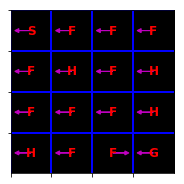

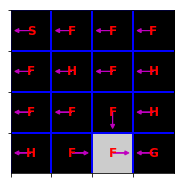

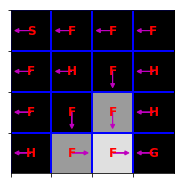

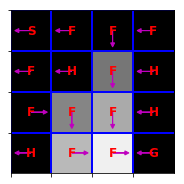

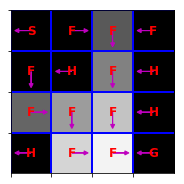

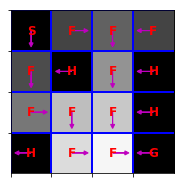

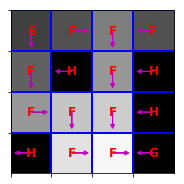

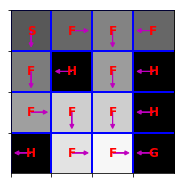

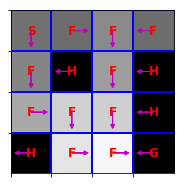

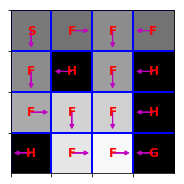

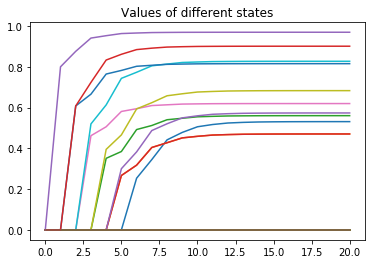

In [107]:
import matplotlib.pyplot as plt
%matplotlib inline
for (V, pi) in zip(Vs_VI[:10], pis_VI[:10]):
    plt.figure(figsize=(3,3))
    plt.imshow(np.array(V).reshape(4,4), cmap='gray', interpolation='none', clim=(0,1))  
    print V
    print np.array(pi).reshape(4,4)
    print("-------")
    ax = plt.gca()
    ax.set_xticks(np.arange(4)-.5)
    ax.set_yticks(np.arange(4)-.5)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    Y, X = np.mgrid[0:4, 0:4]
    a2uv = {0: (-1, 0), 1:(0, -1), 2:(1,0), 3:(-1, 0)}
    Pi = np.array(pi).reshape(4,4)
    for y in range(4):
        for x in range(4):
            a = Pi[y, x]
            u, v = a2uv[a]
            plt.arrow(x, y,u*.3, -v*.3, color='m', head_width=0.1, head_length=0.1) 
            plt.text(x, y, str(env.desc[y,x].item().decode()),
                     color='r', size=12,  verticalalignment='center',
                     horizontalalignment='center', fontweight='bold')
    plt.grid(color='b', lw=2, ls='-')
plt.figure()
plt.plot(Vs_VI)
plt.title("Values of different states");

## Problem 2: construct an MDP where value iteration takes a long time to converge

When we ran value iteration on the frozen lake problem, the last iteration where an action changed was iteration 6--i.e., value iteration computed the optimal policy at iteration 6.
Are there any guarantees regarding how many iterations it'll take value iteration to compute the optimal policy?
There are no such guarantees without additional assumptions--we can construct the MDP in such a way that the greedy policy will change after arbitrarily many iterations.

Your task: define an MDP with at most 3 states and 2 actions, such that when you run value iteration, the optimal action changes at iteration >= 50. Use discount=0.95. (However, note that the discount doesn't matter here--you can construct an appropriate MDP with any discount.)

In [6]:
chg_iter = 50
# YOUR CODE HERE
# Your code will need to define an MDP (mymdp)
# like the frozen lake MDP defined above
begin_grading()
Vs, pis = value_iteration(mymdp, gamma=GAMMA, nIt=chg_iter+1)
end_grading()


Iteration | max|V-Vprev| | # chg actions | V[0]
----------+--------------+---------------+---------
   0      | 1.00000      |  N/A          | 1.000
   1      | 0.05441      |    0          | 1.000
   2      | 0.05169      |    0          | 1.000
   3      | 0.04910      |    0          | 1.000
   4      | 0.04665      |    0          | 1.000
   5      | 0.04431      |    0          | 1.000
   6      | 0.04210      |    0          | 1.000
   7      | 0.03999      |    0          | 1.000
   8      | 0.03799      |    0          | 1.000
   9      | 0.03609      |    0          | 1.000
  10      | 0.03429      |    0          | 1.000
  11      | 0.03258      |    0          | 1.000
  12      | 0.03095      |    0          | 1.000
  13      | 0.02940      |    0          | 1.000
  14      | 0.02793      |    0          | 1.000
  15      | 0.02653      |    0          | 1.000
  16      | 0.02521      |    0          | 1.000
  17      | 0.02395      |    0          | 1.000
  18      | 0.022

## Problem 3: Policy Iteration

The next task is to implement exact policy iteration (PI), which has the following pseudocode:

---
Initialize $\pi_0$

For $n=0, 1, 2, \dots$
- Compute the state-value function $V^{\pi_{n}}$
- Using $V^{\pi_{n}}$, compute the state-action-value function $Q^{\pi_{n}}$
- Compute new policy $\pi_{n+1}(s) = \operatorname*{argmax}_a Q^{\pi_{n}}(s,a)$
---

Below, you'll implement the first and second steps of the loop.

### Problem 3a: state value function

You'll write a function called `compute_vpi` that computes the state-value function $V^{\pi}$ for an arbitrary policy $\pi$.
Recall that $V^{\pi}$ satisfies the following linear equation:
$$V^{\pi}(s) = \sum_{s'} P(s,\pi(s),s')[ R(s,\pi(s),s') + \gamma V^{\pi}(s')]$$
You'll have to solve a linear system in your code.

In [50]:
print('pi',pi)
print('pi(1)',pi[1])
print('pis_VI[0][15]',pis_VI[0][14])
print('mdp.P[1][pi[1]]',mdp.P[1][pi[1]])
a = np.arange(25).reshape(5,5)
b = np.arange(5)
#print(a)
#print(b)
#print(np.einsum('ii', a))
#print(np.einsum('ii->i', a))
#print(np.einsum('ij,j', a, b))
def compute_vpi(pi, mdp, gamma):
    # YOUR CODE HERE
    P = []
    R = []
    for s in range(mdp.nS):
       prob,nexts,r = zip(*mdp.P[s][pi[s]]) 
       prob,nexts,r = list(prob), list(nexts), list(r)
       ps = np.zeros(mdp.nS) 
       rs = np.zeros(mdp.nS)
       ps[nexts] = prob
       rs[nexts] = r
       P += [ps]
       R += [rs]
    
    P = np.array(P)
    R = np.array(R)
       
    # Creating the linear system
    b = - np.einsum('xy,xy->x', P,R)
    A = P*gamma - np.identity(mdp.nS)
    V = np.linalg.solve(A,b)    
    
    return V

compute_vpi(pi, mdp, 0.95)                                

('pi', [1, 2, 1, 0, 1, 0, 1, 0, 2, 1, 1, 0, 0, 2, 2, 0])
('pi(1)', 2)
('pis_VI[0][15]', 2)
('mdp.P[1][pi[1]]', [(0.1, 5, 0.0), (0.8, 2, 0.0), (0.1, 1, 0.0)])


array([ 0.531,  0.471,  0.56 ,  0.471,  0.574,  0.   ,  0.62 , -0.   ,
        0.683,  0.827,  0.815, -0.   , -0.   ,  0.901,  0.97 , -0.   ])

Now let's compute the value of an arbitrarily-chosen policy. 


In [51]:
begin_grading()
print(compute_vpi(np.ones(16), mdp, gamma=GAMMA))
end_grading()


[ 0.016  0.024  0.232  0.024  0.017  0.     0.299 -0.     0.02   0.188
  0.393 -0.     0.     0.196  0.494 -0.   ]



As a sanity check, if we run `compute_vpi` on the solution from our previous value iteration run, we should get approximately (but not exactly) the same values produced by value iteration.

In [111]:
Vpi=compute_vpi(pis_VI[15], mdp, gamma=GAMMA)
V_vi = Vs_VI[15]
print("From compute_vpi", Vpi)
print("------------------")
print("From value iteration", V_vi)
print("------------------")
print("Difference", Vpi - V_vi)

('From compute_vpi\n', array([ 0.531,  0.471,  0.56 ,  0.471,  0.574,  0.   ,  0.62 , -0.   ,
        0.683,  0.827,  0.815, -0.   , -0.   ,  0.901,  0.97 , -0.   ]))
------------------
('From value iteration', [0.53022693598745463, 0.47025522085166149, 0.56020672568388585, 0.47025522085166149, 0.57324999983758707, 0.0, 0.61970564783184334, 0.0, 0.68289414858234276, 0.82706907922479234, 0.81542894842694946, 0.0, 0.0, 0.90102284608485284, 0.96957179821038908, 0.0])
------------------
('Difference', array([  9.580e-04,   3.839e-04,   2.254e-04,   3.839e-04,   4.495e-04,
         0.000e+00,   4.522e-05,  -0.000e+00,   2.612e-04,   1.071e-04,
         3.272e-05,  -0.000e+00,  -0.000e+00,   3.977e-05,   7.051e-06,
        -0.000e+00]))


### Problem 3b: state-action value function

Next, you'll write a function to compute the state-action value function $Q^{\pi}$, defined as follows

$$Q^{\pi}(s, a) = \sum_{s'} P(s,a,s')[ R(s,a,s') + \gamma V^{\pi}(s')]$$


In [96]:
def compute_qpi(vpi, mdp,  gamma):
    Qpi = np.zeros((mdp.nS, mdp.nA))
    # Make the probability and reward matrices.
    for s in range(mdp.nS):
        for a in range(mdp.nA):
            prob, sprime, r = zip(*mdp.P[s][a])
            prob, sprime, r = np.array(prob), list(sprime), np.array(r)
            Qpi[s,a] = np.dot(prob,(r + gamma*vpi[sprime]))
            

    return Qpi


begin_grading()
Qpi = compute_qpi(np.arange(mdp.nS), mdp, gamma=0.95)
print("Qpi:\n", Qpi)
end_grading()



('Qpi:\n', array([[  0.38 ,   3.135,   1.14 ,   0.095],
       [  0.57 ,   3.99 ,   2.09 ,   0.95 ],
       [  1.52 ,   4.94 ,   3.04 ,   1.9  ],
       [  2.47 ,   5.795,   3.23 ,   2.755],
       [  3.8  ,   6.935,   4.56 ,   0.855],
       [  4.75 ,   4.75 ,   4.75 ,   4.75 ],
       [  4.94 ,   8.74 ,   6.46 ,   2.66 ],
       [  6.65 ,   6.65 ,   6.65 ,   6.65 ],
       [  7.6  ,  10.735,   8.36 ,   4.655],
       [  7.79 ,  11.59 ,   9.31 ,   5.51 ],
       [  8.74 ,  12.54 ,  10.26 ,   6.46 ],
       [ 10.45 ,  10.45 ,  10.45 ,  10.45 ],
       [ 11.4  ,  11.4  ,  11.4  ,  11.4  ],
       [ 11.21 ,  12.35 ,  12.73 ,   9.31 ],
       [ 12.16 ,  13.4  ,  14.48 ,  10.36 ],
       [ 14.25 ,  14.25 ,  14.25 ,  14.25 ]]))



Now we're ready to run policy iteration!

Iteration | # chg actions | V[0]
----------+---------------+---------
   0      |      1        | 0.00000
   1      |      7        | -0.00000
   2      |      4        | 0.01352
   3      |      1        | 0.45546
   4      |      0        | 0.53118
   5      |      0        | 0.53118
   6      |      0        | 0.53118
   7      |      0        | 0.53118
   8      |      0        | 0.53118
   9      |      0        | 0.53118
  10      |      0        | 0.53118
  11      |      0        | 0.53118
  12      |      0        | 0.53118
  13      |      0        | 0.53118
  14      |      0        | 0.53118
  15      |      0        | 0.53118
  16      |      0        | 0.53118
  17      |      0        | 0.53118
  18      |      0        | 0.53118
  19      |      0        | 0.53118


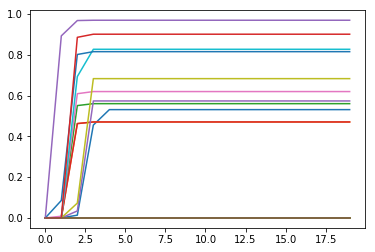

In [99]:
def policy_iteration(mdp, gamma, nIt):
    Vs = []
    pis = []
    pi_prev = np.zeros(mdp.nS,dtype='int')
    pis.append(pi_prev)
    print("Iteration | # chg actions | V[0]")
    print("----------+---------------+---------")
    for it in range(nIt):        
        vpi = compute_vpi(pi_prev, mdp, gamma)
        qpi = compute_qpi(vpi, mdp, gamma)
        pi = qpi.argmax(axis=1)
        print("%4i      | %6i        | %6.5f"%(it, (pi != pi_prev).sum(), vpi[0]))
        Vs.append(vpi)
        pis.append(pi)
        pi_prev = pi
    return Vs, pis
Vs_PI, pis_PI = policy_iteration(mdp, gamma=0.95, nIt=20)
plt.plot(Vs_PI);

Now we can compare the convergence of value iteration and policy iteration on several states.
For fun, you can try adding modified policy iteration.

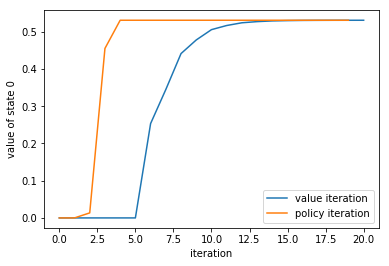

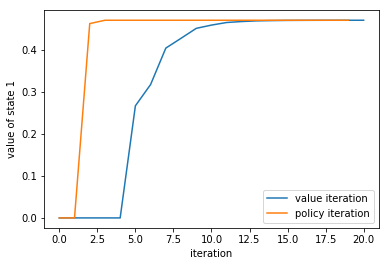

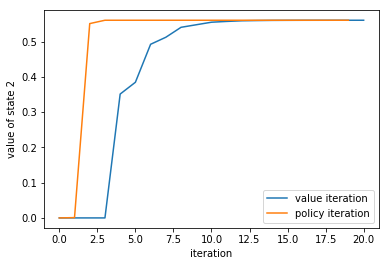

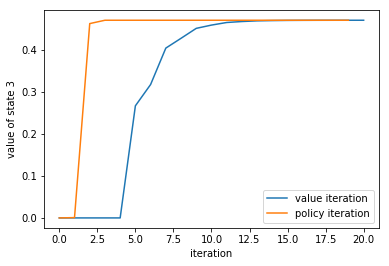

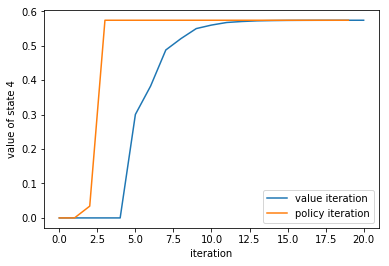

In [101]:
for s in range(5):
    plt.figure()
    plt.plot(np.array(Vs_VI)[:,s])
    plt.plot(np.array(Vs_PI)[:,s])
    plt.ylabel("value of state %i"%s)
    plt.xlabel("iteration")
    plt.legend(["value iteration", "policy iteration"], loc='best')